## Image sample (DDPM - guided diffusion - Diffusion beats gans)

In [1]:
# from __future__ import print_function 
import argparse
import os, sys, glob

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import PIL
import copy
import pytorch_lightning as pl
sys.path.insert(0, '../../')
from guided_diffusion.script_util import (
    seed_all,
)
import importlib

# Sample utils
sys.path.insert(0, '../')
from sample_utils import ckpt_utils, params_utils, vis_utils, file_utils, img_utils, inference_utils

creating the FLAME Decoder


In [2]:
# Settings 
# List model_logs
# cfg_name = "cond_img64_by_deca.yaml"
# log_dir = "img64_cond_by_deca_cont50k"
# cfg_name = "cond_img64_by_light.yaml"
# log_dir = "img64_cond_by_light"
# cfg_name = "all_reduce_nomult.yaml"
# log_dir = "all_reduce_nomult"
cfg_name = "cond_img64_by_deca_arcface.yaml"
# log_dir = "cond_img64_deca_arcface_v2"
log_dir = "cond_img64_by_deca_arcface"
set_ = "valid"

step = "050000"
ckpt_selector = "ema"
ckpt_loader = ckpt_utils.CkptLoader(log_dir=log_dir, cfg_name=cfg_name)
cfg = ckpt_loader.cfg
model_dict, diffusion = ckpt_loader.load_model(ckpt_selector=ckpt_selector, step=step)


[#] Model Path :  ['/data/mint/model_logs/cond_img64_by_deca_arcface/']
['/home/mint/guided-diffusion/config/Various_condition_on_Image/cond_img64_by_deca_arcface.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/Various_condition_on_Image/cond_img64_by_deca_arcface.yaml')

[#] Available ckpt :  ['_000000.pt', '_050000.pt', '_100000.pt', '_150000.pt', '_200000.pt', '_250000.pt', '_300000.pt', '_350000.pt', '_400000.pt', '_450000.pt', '_500000.pt', '_550000.pt', '_600000.pt', '_650000.pt', '_700000.pt']
[#] Loading.../data/mint/model_logs/cond_img64_by_deca_arcface//ImgCond_ema_0.9999_050000.pt


In [3]:
# Load params
params_key = ['shape', 'pose', 'exp', 'cam', 'light', 'faceemb']
params_train, params_train_arr = params_utils.load_params(path="/data/mint/ffhq_256_with_anno/params/train/", params_key=params_key)
params_valid, params_valid_arr = params_utils.load_params(path="/data/mint/ffhq_256_with_anno/params/valid/", params_key=params_key)

Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-light-anno.txt
Key=> faceemb : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-faceemb-anno.txt
Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-light-an

In [4]:
# Load image for condition (if needed)
img_dataset_path = f'/data/mint/ffhq_256_with_anno/ffhq_256/{set_}/'
all_files = file_utils._list_image_files_recursively(img_dataset_path)

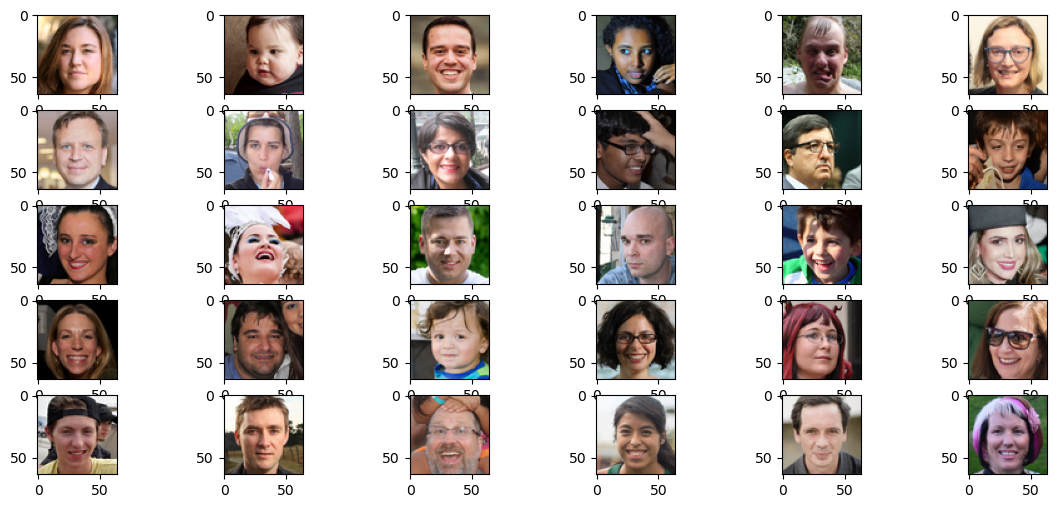

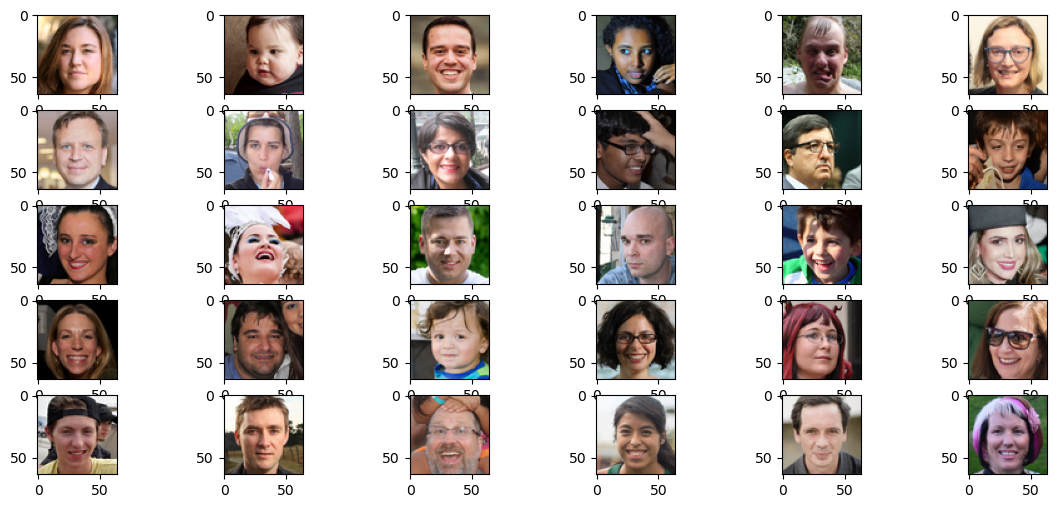

In [5]:
batch_size = 30
base_idx = 11
mode = {'init_noise':'vary_noise', 'cond_params':'vary_cond'}
interchange = None

if set_ == 'train':
    params_set = params_train
elif set_ == 'valid':
    params_set = params_valid
else:
    raise NotImplementedError

seed_all(23)
importlib.reload(inference_utils)
im = inference_utils.InputManipulate(cfg=cfg, params=params_set, batch_size=batch_size, images=all_files)
init_noise, model_kwargs = im.prep_model_input(params_set=params_set, mode=mode, interchange=interchange, base_idx=base_idx)
model_kwargs = im.load_condition(params=params_set)

In [6]:
pl_inference = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, cfg=cfg, sample_fn=diffusion.ddim_sample_loop)
# model_kwargs['cond_params'] = pl_inference.forward_cond_network(model_kwargs=copy.deepcopy(model_kwargs))
sample_ddim = pl_inference(noise=init_noise, model_kwargs=model_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
src_img_list, render_img_list = im.get_image(model_kwargs=model_kwargs, params=params_set, img_dataset_path=img_dataset_path)
src_img = th.cat(src_img_list, dim=0)
render_img = th.cat(render_img_list, dim=0)
vis_utils.plot_sample(img=src_img, render_img=render_img, sampling_img=sample_ddim['img_output'])

# Temporal Consistency (Interpolation Params)

In [ ]:
importlib.reload(inference_utils)
batch_size = 30
base_idx = 11
mode = {'init_noise':'fixed_noise', 'cond_params':'vary_cond'}
interchange=None
interpolate=['light']

if set_ == 'train':
    params_set = params_train
elif set_ == 'valid':
    params_set = params_valid
else:
    raise NotImplementedError

seed_all(23)
im = inference_utils.InputManipulate(cfg=cfg, params=params_set, batch_size=batch_size, images=all_files)
init_noise, model_kwargs = im.prep_model_input(params_set=params_set, mode=mode, interchange=interchange, base_idx=base_idx)
src_idx, dst_idx = 11, 13
model_kwargs['cond_params'] = inference_utils.interpolate_cond(base_cond_params=model_kwargs['cond_params'][[src_idx]],
                                                            src_cond_params=model_kwargs['cond_params'][[src_idx]], 
                                                            dst_cond_params=model_kwargs['cond_params'][[dst_idx]], 
                                                            n_step=batch_size, 
                                                            params_loc=im.cond_params_location(), 
                                                            params_sel=im.cfg.param_model.params_selector, 
                                                            itp_cond=interpolate)

In [ ]:
pl_inference = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, cfg=cfg, sample_fn=diffusion.ddim_sample_loop)
sample_ddim = pl_inference(noise=init_noise, model_kwargs=model_kwargs)

In [ ]:
all_frames = sample_ddim['img_output'].detach().cpu().numpy()

all_frames = list(all_frames)
importlib.reload(img_utils)
img_utils.sequence2video(imgs=all_frames, img_size=cfg.img_model.image_size, save_fn=f'sj{base_idx}')

In [ ]:
vis_utils.plot_sample(img=sample_ddim['img_output'])
src_img_list, render_img_list = im.get_image(model_kwargs=model_kwargs, params=params_set, img_dataset_path=img_dataset_path)
src_img = th.cat(src_img_list, dim=0)
render_img = th.cat(render_img_list, dim=0)
vis_utils.plot_sample(img=src_img, render_img=render_img, sampling_img=sample_ddim['img_output'])

# In-the-wild Images

In [ ]:
# In-the-wild Image
import torch as th
import sys, os

sys.path.insert(0, '../cond_utils/arcface/')
sys.path.insert(0, '../cond_utils/arcface/detector/')
sys.path.insert(0, '../cond_utils/deca/')
from cond_utils.arcface import get_arcface_emb
from cond_utils.deca import get_deca_emb
itw_path = "../itw_images/aligned/"
all_itw_files = file_utils._list_image_files_recursively(itw_path)

# importlib.reload(get_arcface_emb)

device = 'cuda:2'

# ArcFace
faceemb_itw, emb = get_arcface_emb.get_arcface_emb(img_path=itw_path, device=device, arcface_ckpt_path='../cond_utils/arcface/pretrained/BEST_checkpoint_r18.tar')

# DECA
params_dict = {'shape':100, 'pose':6, 'exp':50, 'cam':3, 'light':27, 'faceemb':512,}
deca_itw = get_deca_emb.get_deca_emb(img_path=itw_path, device=device)

assert deca_itw.keys() == faceemb_itw.keys()
params_itw = {}
for img_name in deca_itw.keys():
    params_itw[img_name] = deca_itw[img_name]
    params_itw[img_name].update(faceemb_itw[img_name])

In [ ]:
batch_size = len(params_itw)
seed_all(47)
base_idx = 7
itw_mode = {'init_noise':'fixed_noise', 'cond_params':'vary_cond'}

im_itw = inference_utils.InputManipulate(cfg=cfg, params=params_itw, batch_size=batch_size, images=all_itw_files, sorted=True)
itw_noise = im_itw.get_init_noise(mode=itw_mode['init_noise'], img_size=cfg.img_model.image_size)
itw_kwargs = im_itw.load_condition(params=params_itw)

itw_src_img_list = []
for img_name in itw_kwargs['image_name']:
    itw_src_img = PIL.Image.open(itw_path + img_name).resize((cfg.img_model.image_size, cfg.img_model.image_size))
    itw_src_img = (th.tensor(np.transpose(itw_src_img, (2, 0, 1)))[None, :] / 127.5) - 1
    itw_src_img_list.append(itw_src_img)

itw_src_img = th.cat(itw_src_img_list, dim=0)

In [ ]:
# Interchange the condition
# itw_kwargs['cond_params'] = im_itw.interchange_condition(interchange=['pose'], base_idx=base_idx, cond_params=itw_kwargs['cond_params'])

# Sampling
pl_inference = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, cfg=cfg, sample_fn=diffusion.ddim_sample_loop)
itw_sample_ddim = pl_inference(noise=itw_noise, model_kwargs=itw_kwargs)
vis_utils.plot_sample(img=itw_src_img, sampling_img=itw_sample_ddim['img_output'])


# DDIM Inversion

In [ ]:
itw_path = "../itw_images/aligned/"
device = 'cuda:0'
base_idx = 7
all_itw_files = file_utils._list_image_files_recursively(itw_path)
itw_images = th.tensor(np.stack([img_utils.prep_images(all_itw_files[i], cfg.img_model.image_size) for i in range(len(all_itw_files))], axis=0)).to(device)

im_itw = inference_utils.InputManipulate(cfg=cfg, params=params_itw, batch_size=len(params_itw), images=all_itw_files, sorted=True)
itw_kwargs = im_itw.load_condition(params=params_itw)
itw_kwargs['cond_params'] = itw_kwargs['cond_params'].to(device)

# Reverse
pl_reverse_sampling = inference_utils.PLReverseSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_reverse_sample_loop, cfg=cfg)
reverse_ddim_sample = pl_reverse_sampling(x=itw_images, model_kwargs=itw_kwargs)

# Forward
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_ddim = pl_sampling(noise=reverse_ddim_sample['img_output'], model_kwargs=itw_kwargs)
vis_utils.plot_sample(img=itw_images, reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])

'''
interchange = ['light']
mode = {'init_noise':'fixed_noise', 'cond_params':'vary_cond'}
# # Interchange the condition
itc_itw_kwargs = copy.deepcopy(itw_kwargs)
itc_itw_kwargs['cond_params'] = im_itw.interchange_condition(interchange=interchange, base_idx=base_idx, cond_params=itw_kwargs['cond_params'])
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_ddim = pl_sampling(noise=th.cat([reverse_ddim_sample['img_output'][[base_idx]]] * len(params_itw), dim=0), model_kwargs=itc_itw_kwargs)
vis_utils.plot_sample(img=itw_images, reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])
'''


In [ ]:
mode = {'init_noise':'fixed_noise', 'cond_params':'vary_cond'}
n_step = 20
base_idx = 7
src_idx = 0
dst_idx = 1
n_step = 20
# Interpolate the condition
itp_itw_kwargs = copy.deepcopy(itw_kwargs)
itp_itw_kwargs['cond_params'] = inference_utils.interpolate_cond(base_cond_params=copy.deepcopy(itp_itw_kwargs['cond_params'][[base_idx]]), 
                                                            src_cond_params=copy.deepcopy(itp_itw_kwargs['cond_params'][[src_idx]]), 
                                                            dst_cond_params=copy.deepcopy(itp_itw_kwargs['cond_params'][[dst_idx]]), 
                                                            n_step=n_step, 
                                                            params_loc=im.cond_params_location(), 
                                                            params_sel=im.cfg.param_model.params_selector, 
                                                            itp_cond=['light'])

pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_ddim = pl_sampling(noise=th.cat([reverse_ddim_sample['img_output'][[base_idx]]] * n_step, dim=0), model_kwargs=itp_itw_kwargs)
vis_utils.plot_sample(img=itw_images[:n_step], reverse_sampling_image=th.cat([reverse_ddim_sample['img_output'][[base_idx]]] * n_step, dim=0), sampling_img=sample_ddim['img_output'])

tc_frames = sample_ddim['img_output'].detach().cpu().numpy()
tc_frames = list(tc_frames)
img_utils.sequence2video(imgs=tc_frames, img_size=cfg.img_model.image_size, save_path='./', save_fn='gg_fixed')

# Modified specific condition

In [ ]:
mode = {'init_noise':'fixed_noise', 'cond_params':'vary_cond'}
n_step = 20
base_idx = 7
src_idx = base_idx
dst_idx = 1
n_step = 20
importlib.reload(inference_utils)
# Interpolate the condition
itp_itw_kwargs = copy.deepcopy(itw_kwargs)
itp_itw_kwargs['cond_params'] = inference_utils.modify_cond(cond_params=copy.deepcopy(itp_itw_kwargs['cond_params'][[base_idx]]), 
                                                            mod_idx=[0, 1, 2],
                                                            bound=5,
                                                            n_step=n_step, 
                                                            params_loc=im.cond_params_location(), 
                                                            params_sel=im.cfg.param_model.params_selector, 
                                                            force_zero=True,
                                                            mod_cond=['light'])

pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_ddim = pl_sampling(noise=th.cat([reverse_ddim_sample['img_output'][[base_idx]]] * n_step, dim=0), model_kwargs=itp_itw_kwargs)
vis_utils.plot_sample(img=itw_images[:n_step], reverse_sampling_image=th.cat([reverse_ddim_sample['img_output'][[base_idx]]] * n_step, dim=0), sampling_img=sample_ddim['img_output'])

tc_frames = sample_ddim['img_output'].detach().cpu().numpy()
tc_frames = list(tc_frames)
img_utils.sequence2video(imgs=tc_frames, img_size=cfg.img_model.image_size, save_path='./', save_fn='mod_cond')

# Slerp the noise

In [ ]:
base_idx = 7
src_idx = 0
dst_idx = 1
n_step = 20
interp_noise = inference_utils.interpolate_noise(base_noise=copy.deepcopy(reverse_ddim_sample['img_output'][base_idx].flatten()), 
                                                                src_noise=copy.deepcopy(reverse_ddim_sample['img_output'][base_idx].flatten()), 
                                                                dst_noise=copy.deepcopy(th.randn(reverse_ddim_sample['img_output'][base_idx].flatten().shape)), 
                                                                n_step=n_step, 
                                                                interp_fn=inference_utils.slerp)

interp_noise = th.tensor(interp_noise.reshape((n_step, 3, 64, 64))).cuda()

pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_ddim = pl_sampling(noise=interp_noise, model_kwargs=itp_itw_kwargs)
vis_utils.plot_sample(img=itw_images[:n_step], reverse_sampling_images=interp_noise, sampling_img=sample_ddim['img_output'])

tc_frames = sample_ddim['img_output'].detach().cpu().numpy()
tc_frames = list(tc_frames)
img_utils.sequence2video(imgs=tc_frames, img_size=cfg.img_model.image_size, save_path='./', save_fn='gg')
# interp_noise = [np.transpose(decolor(interp_noise[i], out_c='rgb').cpu().numpy(), (1, 2, 0)) for i in range(interp_noise.shape[0])]
# for i in range(10):
#     plt.imshow(interp_noise[i])
#     plt.show()